# Sampling of catalogue data with external information
$\texttt{lenstronomy}$ was originally developed to simulate and model imaging data. The modular design allows to model and sample data in catalogue form too. In this notebook, we consider the modelling of a quadruply imaged (quasar) lens.

In a first step, we simulate a quad lens and compute the following mock data products:

- image positions (with astrometric uncertainties)
- relative time delays (with uncertainties)

In a section step, we use this mock data to sample the lens model parameter space and time-delay distance with an additional external imposed prior in the sampler. This prior can come from e.g. a BNN output.

In [1]:
# import the necessary python modules
import numpy as np
import time
import corner

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util import constants
from astropy.cosmology import FlatLambdaCDM
from  lenstronomy.Plots import lens_plot

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(21)

## generating mock catalogue data

image positions are:  [ 0.91408672 -0.46772437  0.637908   -0.71115673] [-0.64567081  0.89959973  0.72135406 -0.47514408]
point source magnification:  [ 3.70105075  5.14423341 -3.9686371  -2.20085329]
time delays:  [-56.55938764 -48.60968371 -43.62200746 -33.46569301]


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


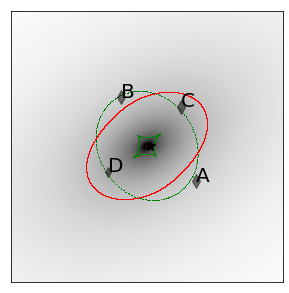

In [2]:
# the redshifts of lens and source and the cosmology is only used when predicting the relative time delays between the images
z_lens = 0.5
z_source = 1.5

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source)


# make class instances for a chosen lens model type

# chose a lens model
lens_model_list = ['PEMD', 'SHEAR']
# make instance of LensModel class
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens, z_source=z_source)
# make instance of LensEquationSolver to solve the lens equation
lensEquationSolver = LensEquationSolver(lensModel=lensModel)

# make choice of lens model

# we chose a source position (in units angle) 
x_source, y_source = 0.07, 0.01
# we chose a lens model
kwargs_lens = [{'theta_E': 1., 'e1': 0.1, 'e2': 0.2, 'gamma': 2., 'center_x': 0, 'center_y': 0},
              {'gamma1': 0.05, 'gamma2': -0.01}]


# compute image positions and their (finite) magnifications

# we solve for the image position(s) of the provided source position and lens model
x_img, y_img = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, sourcePos_x=x_source, 
                                                             sourcePos_y=y_source)
print('image positions are: ', x_img, y_img)
# the infinitesimal magnification at the position of the images is:
mag_inf = lensModel.magnification(x_img, y_img, kwargs_lens)
print('point source magnification: ', mag_inf)




# here are the predicted time delays in units of days
t_days = lensModel.arrival_time(x_img, y_img, kwargs_lens)
print('time delays: ', t_days)

# here we plot the lens model, including (optional) the caustics and critical curves
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=x_source, sourcePos_y=y_source, point_source=True, with_caustics=True)
f.show()


## Set up data for modeling
In the previous box, we created a mock lens and computed image positions, flux ratios and time delays.
In this section, we explicitly set up the data products that we want to use for the modeling. You can replace this box with the values for the lens you want to model.

In [3]:
# the data set is taken from the mock data above (can be replaced by real data)
# image positions in relative RA (arc seconds)
ximg = x_img  # image positions in relative RA (arc seconds)
yimg = y_img  # image positions in relative DEC (arc seconds)


astrometry_sigma = 0.005  # 1-sigma astrometric uncertainties of the image positions (assuming equal precision for all images in RA/DEC directions)

# time delays
d_dt = t_days[1:] - t_days[0]  # lenstronomy definition of relative time delay is in respect of first image in the list (full covariance is in planning)
d_dt_sigma = np.array([0.25, 0.25, 0.25])  # 1-sigma uncertainties in the time-delay measurement (in units of days)
d_dt_measured = d_dt + np.random.normal(0, d_dt_sigma)

ximg_measured = ximg + np.random.normal(0, astrometry_sigma, 4)
yimg_measured = yimg + np.random.normal(0, astrometry_sigma, 4)
# here we create a keyword list with all the data elements. If you only have partial information about your lens,
# only provide the quantities you have.
kwargs_data_joint = {'time_delays_measured': d_dt_measured,
                     'time_delays_uncertainties': d_dt_sigma,
                    'ra_image_list': [ximg_measured], 'dec_image_list': [yimg_measured]}


## Model settings
Here we set up the modeling (initial guess of the parameters, uncertainties and lower and upper bounds. In this example, we chose the same lens model as we produced the mock data and thus expect a perfect fit.
This part is equal to the imaging simulation of lenstronomy. We refer to other notebooks and the documentation for more details.

In [4]:
# ==================
# lens model choices
# ==================
lens_model_list = ['PEMD', 'SHEAR']

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# PEMD parameters
fixed_lens.append({}) 
# initial parameter guess
#kwargs_lens_init.append(kwargs_lens[0])
kwargs_lens_init.append({'theta_E': 1., 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0.})
# initial particle clowd
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
# hard bound lower limit of parameters
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
# hard bound upper limit of parameters
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

# SHEAR parameters
# we keep the center of shear definition fixed at (0,0)
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.0, 'gamma2': 0.0})
kwargs_lens_sigma.append({'gamma1': 0.05, 'gamma2': 0.05})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

# combine all parameter options for lenstronomy
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


# =========================
# image position parameters
# =========================

# we chose to model the image positions in the lensed plane (we know where they appear)
point_source_list = ['LENSED_POSITION']
# We fix the image position coordinates.
fixed_ps = [{}]
kwargs_ps_init = [{'ra_image': ximg_measured, 'dec_image': yimg_measured}] # the initial guess for the appearing image positions is: at the image position.
kwargs_ps_sigma = [{'ra_image': astrometry_sigma * np.ones(len(ximg)), 'dec_image': astrometry_sigma * np.ones(len(ximg))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(ximg)), 'dec_image': -10 * np.ones(len(ximg))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(ximg)), 'dec_image': 10 * np.ones(len(ximg))}]

# combine all parameter options for lenstronomy
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]


fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}



# ===================
# Time-delay distance
# ===================

# with time-delay information, we can measure the time-delay distance (units physical Mpc)

# if you want to fix the cosmology and instead use the time-delay information to constrain the lens model, out-comment the line below
#fixed_special['D_dt'] = lensCosmo.D_dt
kwargs_special_init['D_dt'] = 3000
kwargs_special_sigma['D_dt'] = 200
kwargs_lower_special['D_dt'] = 0
kwargs_upper_special['D_dt'] = 100000

special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]

# combined parameter settings
kwargs_params = {'lens_model': lens_params,
                'point_source_model': ps_params,
                'special': special_params}

# our model choices
kwargs_model = {'lens_model_list': lens_model_list, 
                'point_source_model_list': point_source_list
                 }


## setup options for likelihood and parameter sampling
In $\texttt{lenstronomy}$ the likelihood settings (which likelihood gets evaluated) and the parameter sampling options (which parameters get sampled) are separated. It is upon the user to decide the appropriate parameters to be sampled for the given choice of likelihoods.

In [5]:
time_delay_likelihood = True  # bool, set this True or False depending on whether time-delay information is available and you want to make use of its information content.
image_position_likelihood = True  # bool, evaluating the image position likelihood (in combination with astrometric errors)


kwargs_constraints = {'num_point_source_list': [len(ximg)],  
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeld
                      'Ddt_sampling': time_delay_likelihood,  # sampling of the time-delay distance                      
                     }

# we can define un-correlated Gaussian priors on specific parameters explicitly

# e.g. power-law mass slope of the main deflector
prior_lens = [[0, 'gamma', 2, 0.1]] # [[index_model, 'param_name', mean, 1-sigma error], [...], ...]
# e.g. source size of the emission region
#prior_special = [['source_size', source_size_arcsec, 0.01]]
prior_special = []

# we can also define custom functions to be added to the likelihood, either as a stand alone definition
# or as a class instance with a __call__() method

class LikelihoodAddition(object):
    import numpy as np
    
    def __init__(self):
        pass

    def __call__(self, kwargs_lens=None, kwargs_source=None, kwargs_lens_light=None, kwargs_ps=None, kwargs_special=None, kwargs_extinction=None):
        return self.logL_addition(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps, kwargs_special, kwargs_extinction)

    def logL_addition(self, kwargs_lens, kwargs_source=None, kwargs_lens_light=None, kwargs_ps=None, kwargs_special=None, kwargs_extinction=None):
        """
        a definition taking as arguments (kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps, kwargs_special, kwargs_extinction)
                and returns a logL (punishing) value.
        """
        # Gaussian prior on the power-law slope
        gamma_mean = 2
        gamma_sigma = 0.1

        gamma_measured = kwargs_lens[0]['gamma']
        logL = - (gamma_measured - gamma_mean)**2 / gamma_sigma**2 / 2
        # hard cut flat prior on the axis ratio b/a of the lens mass distribution
        q_cut = 0.5
        e1, e2 = kwargs_lens[0]['e1'], kwargs_lens[0]['e2']
        c = np.sqrt(e1**2+e2**2)
        c = np.minimum(c, 1.)
        q = (1-c)/(1+c)
        if q < q_cut:
            return -np.inf
        # Gaussian prior on the lens excentricities
        e1_mean, e2_mean = 0.1, 0.2
        e_sigma = 0.05
        logL -= (e1 - e1_mean)**2 / e_sigma**2 / 2
        logL -= (e2 - e2_mean)**2 / e_sigma**2 / 2
        
        gamma1, gamma2 = kwargs_lens[1]['gamma1'], kwargs_lens[1]['gamma2']
        gamma1_mean, gamma2_mean = 0.05, -0.01
        gamma_sigma = 0.02
        logL -= (gamma1 - gamma1_mean)**2 / gamma_sigma**2 / 2
        logL -= (gamma2 - gamma2_mean)**2 / gamma_sigma**2 / 2
        return logL

logL_addition = LikelihoodAddition()
    
    
kwargs_likelihood = {  
                     'image_position_uncertainty': astrometry_sigma,  # astrometric uncertainty of image positions
                     #'source_position_likelihood': False,  # evaluates how close the different image positions match the source positons
                     'image_position_likelihood': True, # evaluate point source likelihood given the measured image positions
                     'time_delay_likelihood': time_delay_likelihood,  # evaluating the time-delay likelihood
                     #'prior_lens': prior_lens,
                     'prior_special': prior_special,
                     'check_matched_source_position': True, # check non-linear solver and disgard non-solutions
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'check_bounds': True,  # check parameter bounds and punish them
                     'custom_logL_addition': logL_addition
                    }


## Run the modeling - Particle Swarm Optimization to find a maxima in the likelihood

In [6]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [#['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],  # you can add additional fixed parameters if you want
                       ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],]

start_time = time.time()
chain_list_pso = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')



/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.15054191624900193 reduced X^2 of best position
-0.07527095812450096 logL
-1 effective number of data points
[{'theta_E': 0.9997323486671, 'gamma': 1.9988983724589728, 'e1': 0.09187109847686294, 'e2': 0.20403730441376622, 'center_x': -0.0075616863481747145, 'center_y': -0.0026567741006327944}, {'gamma1': 0.04406454029077731, 'gamma2': -0.009427253727143597, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[] lens light result
[{'ra_image': array([ 0.90790747, -0.46415157,  0.62952555, -0.71230917]), 'dec_image': array([-0.64691198,  0.9048786 ,  0.72139595, -0.47788377]), 'point_amp': [1, 1, 1, 1]}] point source result
{'D_dt': 3301.334461613593} special param result
359.4417989253998 time used for  PSO
359.4721260070801 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


time-delay logL = -0.007631166961542344
Source scatter punishing likelihood = -2.7790859125708144e-22
image position likelihood -0.00665618830444988
Prior likelihood = 0
custom added logL = -0.06098360285850875
{'D_dt': 3301.334461613593}


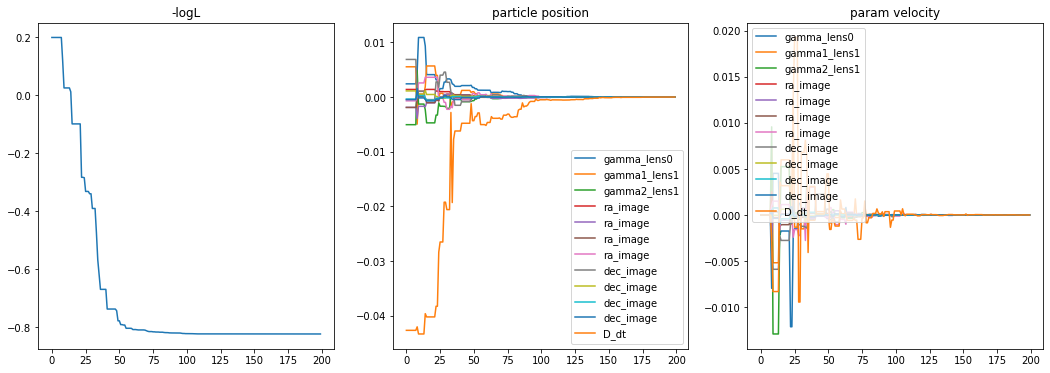

<Figure size 432x288 with 0 Axes>

In [7]:
kwargs_result = fitting_seq.best_fit(bijective=True)
args_result = fitting_seq.param_class.kwargs2args(**kwargs_result)
logL = fitting_seq.likelihoodModule.logL(args_result, verbose=True)
print(kwargs_result['kwargs_special'])

from lenstronomy.Plots import chain_plot as chain_plot
for i in range(len(chain_list_pso)):
    chain_plot.plot_chain_list(chain_list_pso, i)

## MCMC posterior sampling

In [8]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['MCMC', {'n_burn': 100, 'n_run': 200, 'walkerRatio': 10, 'sigma_scale': 1}]
]
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

  0%|          | 0/300 [00:00<?, ?it/s]/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 300/300 [06:17<00:00,  1.23s/it]

Computing the MCMC...
Number of walkers =  120
Burn-in iterations:  100
Sampling iterations (in current run): 300
378.730211019516 time taken for MCMC sampling


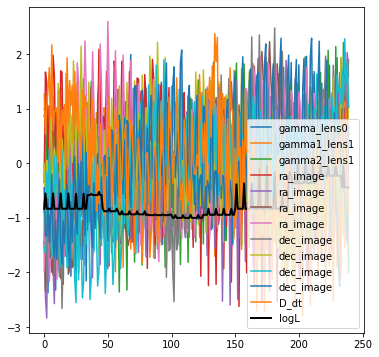

In [9]:
for i in range(len(chain_list_pso)):
    chain_plot.plot_chain_list(chain_list_mcmc, i)

## Post-processing the chains 

In [10]:

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list_mcmc[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])



# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
# make instance of parameter class with given model options, constraints and fixed parameters
# this allows to recover the full parameters of all model components, not just the ones being sampled.

param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, kwargs_fixed_special=fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


lensModel = LensModel(kwargs_model['lens_model_list'])
lensModelExtensions = LensModelExtensions(lensModel=lensModel) 


mcmc_new_list = []
labels_new = [r"$\theta_E$", r"$\gamma$", r"$\phi_{lens}$", r"$q$", r"$\phi_{ext}$", r"$\gamma_{ext}$"]
if time_delay_likelihood is True:
    labels_new.append(r"$D_{dt}$")


number of non-linear parameters in the MCMC process:  12
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  24000


In [11]:
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_out = param.args2kwargs(samples_mcmc[i])
    kwargs_lens_out, kwargs_special_out, kwargs_ps_out = kwargs_out['kwargs_lens'], kwargs_out['kwargs_special'], kwargs_out['kwargs_ps']
    
    # compute 'real' image position adding potential astrometric shifts
    x_pos, y_pos = kwargs_ps_out[0]['ra_image'], kwargs_ps_out[0]['dec_image']
    
    # extract quantities of the main deflector
    theta_E = kwargs_lens_out[0]['theta_E']
    gamma = kwargs_lens_out[0]['gamma']
    e1, e2 = kwargs_lens_out[0]['e1'], kwargs_lens_out[0]['e2']
    phi, q = param_util.ellipticity2phi_q(e1, e2)
    phi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_lens_out[1]['gamma1'], kwargs_lens_out[1]['gamma2'])
    new_chain = [theta_E, gamma, phi, q, phi_ext, gamma_ext]
    if time_delay_likelihood is True:
        D_dt = kwargs_special_out['D_dt']
        new_chain.append(D_dt)
    
    #source_size = np.random.uniform(high=1, low=0)
    mcmc_new_list.append(np.array(new_chain))

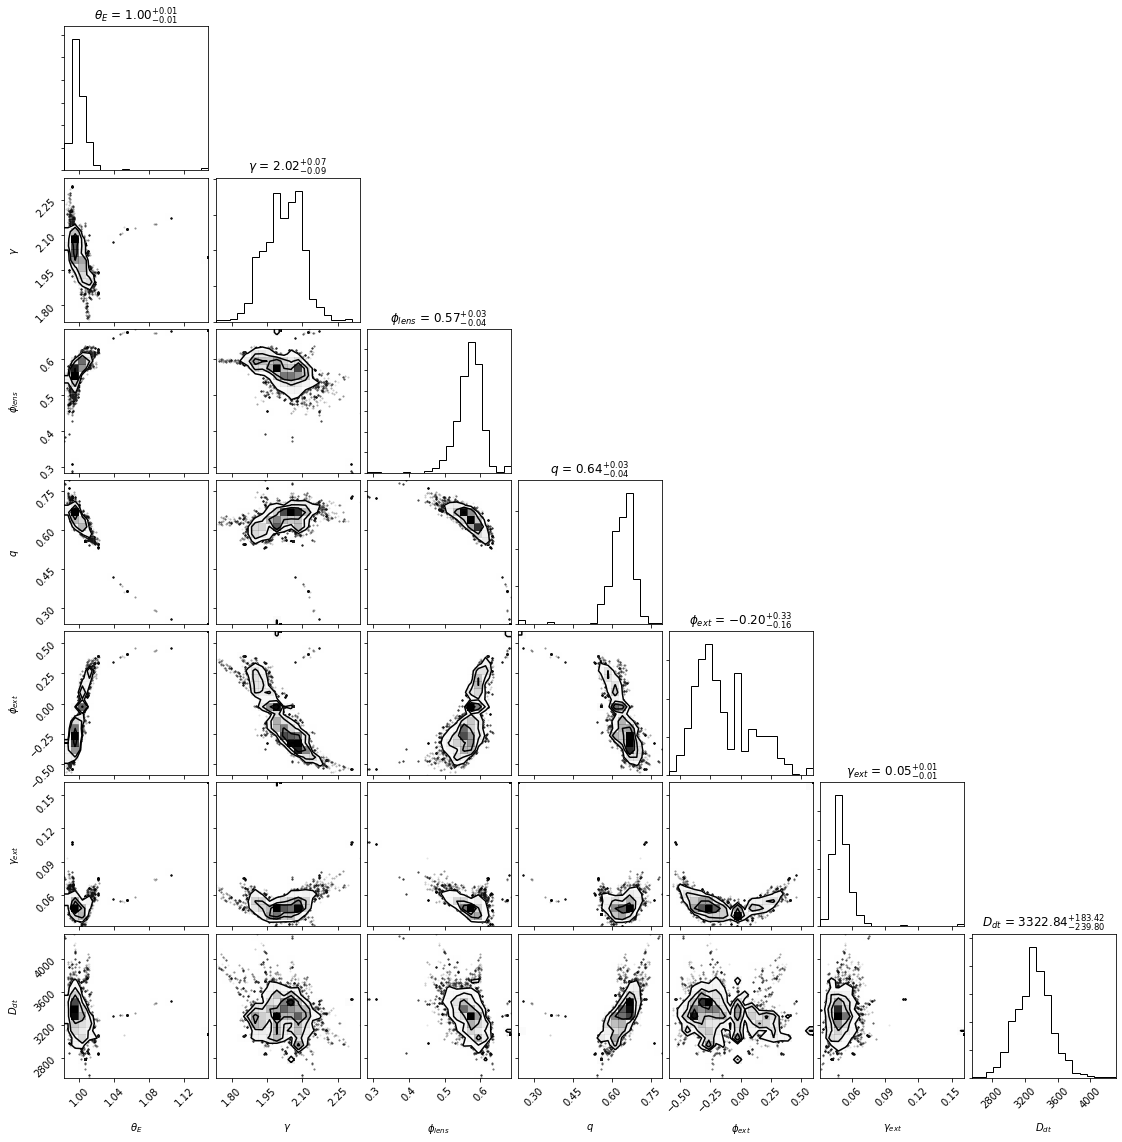

In [12]:
plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True)


In [13]:
print(lensCosmo.ddt)
print(kwargs_result)

3329.6653609254795
{'kwargs_lens': [{'theta_E': 1.0021442494492936, 'gamma': 1.959600765473933, 'e1': 0.08920789019486502, 'e2': 0.2058771328910035, 'center_x': -0.008421232118078771, 'center_y': -0.0034309276474649222}, {'gamma1': 0.04399684896436814, 'gamma2': -0.001874168857496259, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [], 'kwargs_ps': [{'ra_image': array([ 0.90804466, -0.46546607,  0.62905777, -0.71217641]), 'dec_image': array([-0.65138607,  0.90556143,  0.72221706, -0.47747375]), 'point_amp': [1, 1, 1, 1]}], 'kwargs_special': {'D_dt': 3359.1155635753785}, 'kwargs_extinction': []}
